# Gene Expression Analysis and Graph Neural Network (GNN) for Breast Cancer Classification

This Notebook provides a workflow for analyzing gene expression data and implementing a Graph Neural Network (GNN) model to classify cancer subtypes.

Data Source: [Curated Microarray Database (CuMiDa)](https://www.kaggle.com/datasets/brunogrisci/breast-cancer-gene-expression-cumida/data)

## Sections Overview

1. **Importing Libraries**: This section imports all the necessary libraries required for data manipulation, visualization, and model building.

2. **Exploratory Data Analysis (EDA)**:
    - **Loading Data**: Load the gene expression dataset.
    - **Looking at the First Few Rows of the Data**: Display the first few rows of the dataset.
    - **Summary of the Data**: Provide a summary of the dataset, including data types and missing values.
    - **Distribution of Cancer Subtypes**: Analyze the distribution of different cancer subtypes in the dataset.
    - **Descriptive Statistics for the First 10 Gene Features**: Display descriptive statistics for the first 10 gene features.
    - **Missing Values in the Data**: Check for missing values in the dataset.
    - **Total Null Count**: Calculate the total number of missing values.
    - **Class Distribution of 'type'**: Analyze the class distribution of the target variable 'type'.
    - **Visualizing the Class Distribution**: Visualize the distribution of cancer subtypes using bar plots and pie charts.
    - **Analyze Basic Statistics of Gene Features**: Provide summary statistics for all gene features.
    - **Identify the Most Variable Features**: Identify and display the most variable gene features.
    - **Visualize the Distribution of the Top 10 Most Variable Genes**: Visualize the distribution of the top 10 most variable genes.

3. **Dimensionality Reduction**:
    - **Separate Features and Target Label**: Separate the gene features from the target labels.
    - **Select the Top 1000 Most Variable Genes for Dimensionality Reduction**: Select and normalize the top 1000 most variable genes.
    - **Save the Processed Dataset**: Save the processed dataset for further steps.

4. **Graph Creation**:
    - **Define Nodes**: Define nodes representing patients with their gene expression profiles.
    - **Define Edges**: Define edges based on cosine similarity between patients' gene expression profiles.
    - **Create Graph**: Create a graph using the NetworkX library.
    - **Visualize Graph**: Visualize the patient similarity graph.
    - **Save Graph**: Save the graph data for further use in the GNN model.

5. **Implement the GNN Model**:
    - **Load the Graph Data**: Load the edges, node features, and labels from the preprocessed data files.
    - **Train-Test Split**: Split the data into training and testing sets.
    - **Define the GNN Model**: Define a Graph Convolutional Network (GCN) model.
    - **Define Loss and Optimizer**: Define the loss function and optimizer for training the model.
    - **Train the Model with Gradient Clipping and Early Stopping**: Train the model with gradient clipping and early stopping to prevent overfitting.
    - **Visualizations of Model Performance**: Visualize the training loss and test accuracy over epochs.
    - **Confusion Matrix**: Plot the confusion matrix to evaluate the model's performance on the test set.

# Importing Libraries

In [249]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv

# Exploratory Data Analysis (EDA)

### Loading Data

In [251]:
data = pd.read_csv('../data/input_data/gene-expression-CuMiDa.csv')

data.shape

(151, 54677)

### Looking at the First Few Rows of the Data

In [252]:
data.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


### Summary of the Data

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), int64(1), object(1)
memory usage: 63.0+ MB


### Distribution of Cancer Subtypes

In [254]:
data.type.value_counts()

type
basal        41
HER          30
luminal_B    30
luminal_A    29
cell_line    14
normal        7
Name: count, dtype: int64

### Descriptive Statistics for the First 10 Gene Features

In [255]:
data.iloc[:, :10].describe()

,samples,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,160.668874,10.338901,7.631910,6.224885,7.339248,3.185252,7.310240,5.323484,4.714095
std,45.431226,0.613445,0.706464,0.645435,0.330827,0.158909,0.642091,0.294513,0.308550
min,84.000000,7.505488,5.855968,4.763602,6.632206,2.760583,5.455736,4.646131,3.946065
25%,121.500000,10.103030,7.166075,5.798087,7.105841,3.075873,6.874504,5.131931,4.466260
50%,159.000000,10.416819,7.531673,6.235074,7.333426,3.187703,7.417113,5.274663,4.662957
75%,200.500000,10.735117,8.053832,6.612291,7.513084,3.280416,7.760806,5.456686,4.941337
max,238.000000,11.675109,9.627008,8.364749,8.374055,3.611630,8.569296,6.360765,5.893006


### Missing Values in the Data

In [256]:
print(data.isna().sum())

samples            0
type               0
1007_s_at          0
1053_at            0
117_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 54677, dtype: int64


### Total Null Count

In [257]:
print(f"Total null count: {data.isna().sum().sum()}")

Total null count: 0


## Check the Class Distribution of 'type'

In [258]:
class_distribution = data['type'].value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
type
basal        41
HER          30
luminal_B    30
luminal_A    29
cell_line    14
normal        7
Name: count, dtype: int64


### Visualizing the Class Distribution

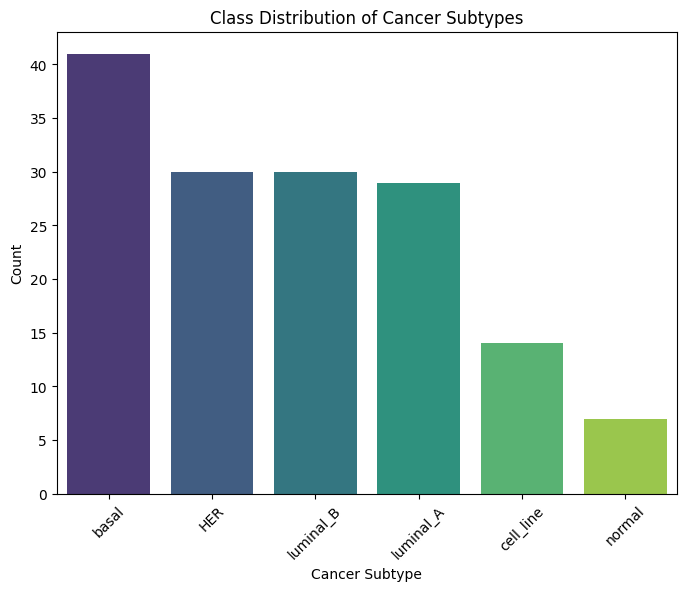

In [263]:
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, hue=class_distribution.index, palette="viridis", dodge=False, legend=False)
plt.title("Class Distribution of Cancer Subtypes")
plt.xlabel("Cancer Subtype")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Visualizing the Distribution of Target Variable

type
basal        41
HER          30
luminal_B    30
luminal_A    29
cell_line    14
normal        7
Name: count, dtype: int64 




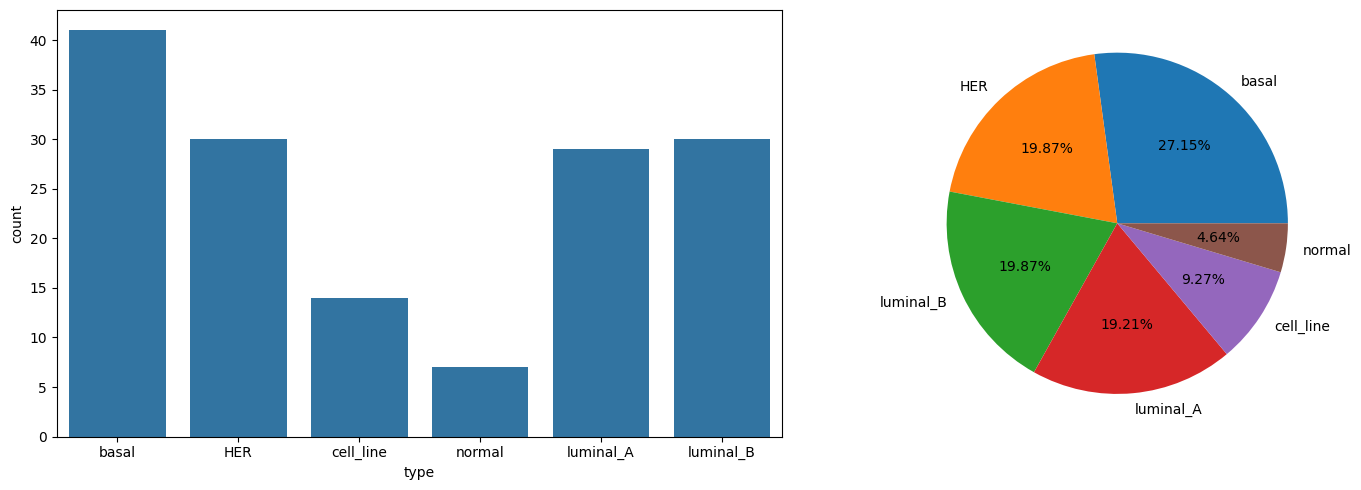

In [264]:
target  = "type"

val_counts = data[target].value_counts()
print(val_counts, "\n\n")

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x = data[target])

plt.subplot(1, 2, 2)
plt.pie(val_counts, labels = val_counts.keys(), autopct = "%.2f%%")

plt.tight_layout()
plt.show()

## Analyze Basic Statistics of Gene Features

In [265]:
gene_features = data.drop(columns=['type'])  # Exclude the target label
summary_statistics = gene_features.describe()
print("Summary Statistics for Gene Features:")
print(summary_statistics)


Summary Statistics for Gene Features:
          samples   1007_s_at     1053_at      117_at      121_at   1255_g_at  \
count  151.000000  151.000000  151.000000  151.000000  151.000000  151.000000   
mean   160.668874   10.338901    7.631910    6.224885    7.339248    3.185252   
std     45.431226    0.613445    0.706464    0.645435    0.330827    0.158909   
min     84.000000    7.505488    5.855968    4.763602    6.632206    2.760583   
25%    121.500000   10.103030    7.166075    5.798087    7.105841    3.075873   
50%    159.000000   10.416819    7.531673    6.235074    7.333426    3.187703   
75%    200.500000   10.735117    8.053832    6.612291    7.513084    3.280416   
max    238.000000   11.675109    9.627008    8.364749    8.374055    3.611630   

          1294_at     1316_at     1320_at   1405_i_at  ...  \
count  151.000000  151.000000  151.000000  151.000000  ...   
mean     7.310240    5.323484    4.714095    7.787712  ...   
std      0.642091    0.294513    0.308550    1

## Identify the Most Variable Features

In [266]:
variances = gene_features.var().sort_values(ascending=False)
most_variable_genes = variances.head(10)
print("Most Variable Gene Features:")
print(most_variable_genes)

Most Variable Gene Features:
samples       2063.996291
206378_at       17.083996
228241_at       13.367385
205916_at       11.137314
237339_at       10.873480
1553602_at      10.690823
209173_at       10.669474
214451_at       10.226708
205009_at        9.880227
205044_at        9.770806
dtype: float64


### Visualize the Distribution of the Top 10 Most Variable Genes

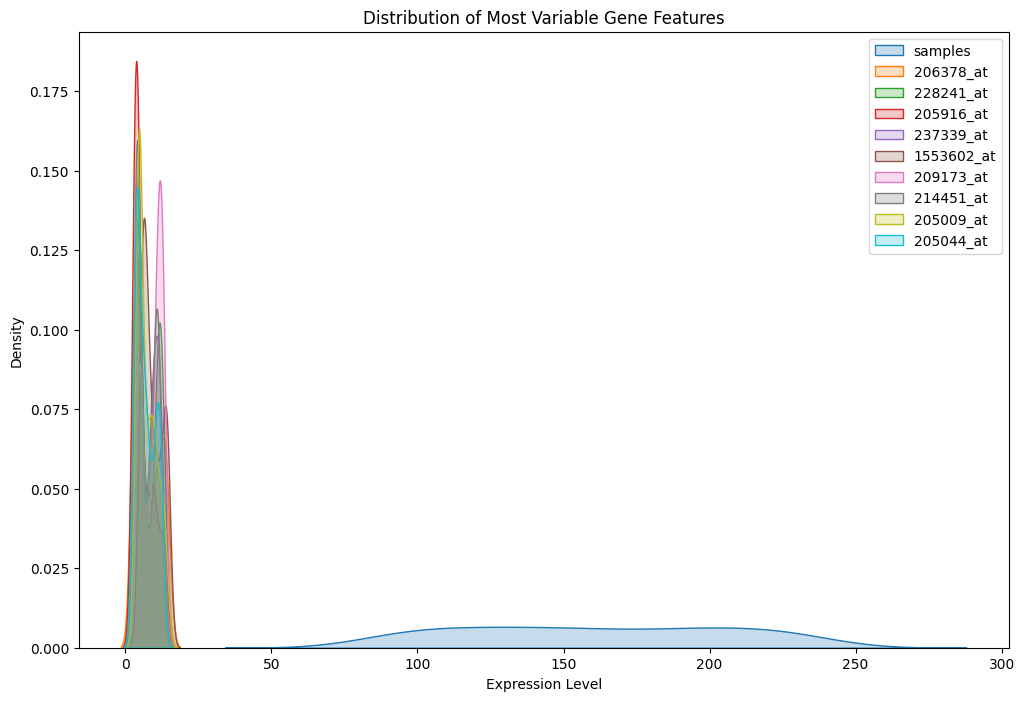

In [267]:
plt.figure(figsize=(12, 8))
for gene in most_variable_genes.index:
    sns.kdeplot(gene_features[gene], label=gene, fill=True)
plt.title("Distribution of Most Variable Gene Features")
plt.xlabel("Expression Level")
plt.ylabel("Density")
plt.legend()
plt.show()

# Dimensionality Reduction

### Seperate Features and Target Label

In [268]:
gene_features = data.drop(columns=['type', 'samples']) 
target_labels = data['type']
sample_ids = data['samples']

### Select the Top 1000 Most Variable Genes for Dimensionality Reduction

In [269]:
# Select the top 1000 most variable genes
variances = gene_features.var().sort_values(ascending=False)
most_variable_genes = variances.head(1000).index
top_gene_features = gene_features[most_variable_genes]

# Normalize the selected features
scaler = StandardScaler()
top_gene_features_normalized = pd.DataFrame(scaler.fit_transform(top_gene_features), columns=most_variable_genes)

In [270]:
# Combine normalized features with target labels
processed_data = pd.concat([sample_ids, top_gene_features_normalized, target_labels], axis=1)

# Save the processed dataset for further steps
processed_data.to_csv('../data/processed_data/processed_gene_expression.csv', index=False)

# Display summary of the processed data
print("Processed Data Shape:", processed_data.shape)
print("First Few Rows of Processed Data:")
print(processed_data.head())

Processed Data Shape: (151, 1002)
First Few Rows of Processed Data:
   samples  206378_at  228241_at  205916_at  237339_at  1553602_at  209173_at  \
0       84  -1.047950  -1.134028   0.322385  -1.196059   -1.087447  -1.453103   
1       85  -0.773411  -1.081919   0.200225  -1.064396   -1.231130  -0.765962   
2       87  -0.993366  -1.158682  -0.932183  -1.046253   -1.238368  -1.630640   
3       90  -1.016293  -0.941043   1.003884  -1.058107   -1.274305  -0.797037   
4       91  -1.079375  -0.725694  -0.595111  -1.065425   -1.393374  -1.380549   

   214451_at  205009_at  205044_at  ...  207165_at  210170_at  203060_s_at  \
0  -0.948098  -1.056173   1.034545  ...   0.639094  -1.442860     0.619823   
1  -0.911955  -1.024586   1.761422  ...   1.153657  -0.939926    -0.696441   
2  -1.012577  -0.913351   1.282975  ...   0.362757  -0.283213     0.194005   
3  -0.994214  -1.045237   1.562270  ...   1.214324  -0.821707    -1.466824   
4  -1.030389  -1.086130   1.781271  ...   0.948188  -1.

# Graph Creation
In this part we focus on creating a graph from the gene expression data of patients. Each patient is represented as a node, and edges are defined based on the cosine similarity of their gene expression profiles. The top 5 most similar patients are connected to each node. The graph is then visualized and saved for further use in a Graph Neural Network (GNN) model.

In [271]:
processed_data = pd.read_csv('../data/processed_data/processed_gene_expression.csv')

### Define Nodes
Each patient is represented as a node in the graph. The node features are the gene expression profiles of the patients.

In [272]:
samples = processed_data['samples']
node_features = processed_data.drop(columns=['samples', 'type'])
node_labels = processed_data['type']

### Define Edges
Edges are defined based on the cosine similarity of the gene expression profiles of the patients. The top 5 most similar patients are connected to each node.

In [273]:
# Calculate cosine similarity between patients based on their gene expression profiles
similarity_matrix = cosine_similarity(node_features)

# Define a threshold for creating edges (e.g., top 5 neighbors for each node)
k = 5
edges = []
for i in range(similarity_matrix.shape[0]):
    neighbors = np.argsort(similarity_matrix[i])[-(k + 1):-1]  # Exclude the node itself
    for neighbor in neighbors:
        edges.append((samples[i], samples[neighbor]))

### Create Graph
The graph is created using the NetworkX library.

In [274]:
graph = nx.Graph()
graph.add_nodes_from(samples)
graph.add_edges_from(edges)

### Visualize Graph

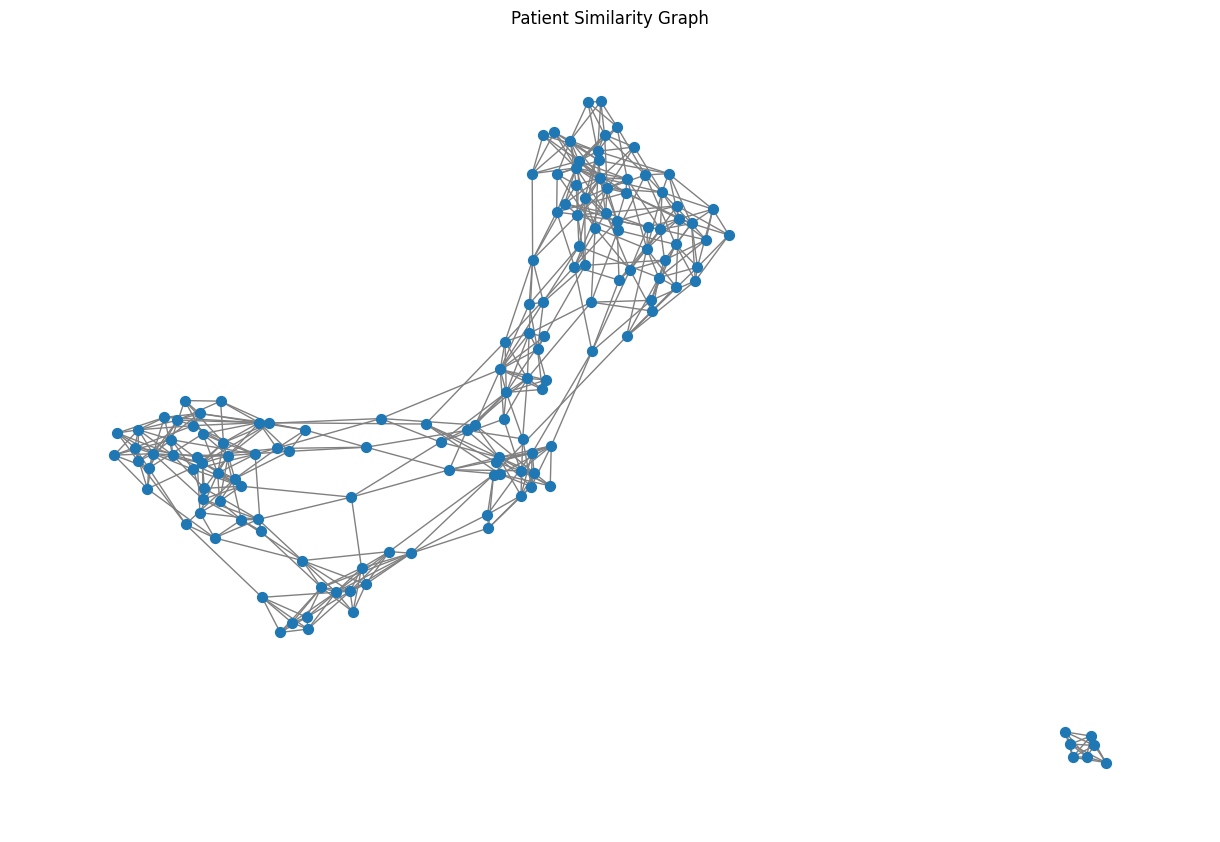

In [275]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph, seed=42)
nx.draw(graph, pos, node_size=50, with_labels=False, edge_color='gray')
plt.title("Patient Similarity Graph")
plt.show()

### Save Graph
Node Features and Node Labels and Edges are saved in a csv file for further use in a Graph Neural Network (GNN) model.

In [279]:
edges_df = pd.DataFrame(edges, columns=['source', 'target'])
node_features.to_csv('../data/graph_data/node_features.csv', index=False)
node_labels.to_csv('../data/graph_data/node_labels.csv', index=False)
edges_df.to_csv('../data/graph_data/edges.csv', index=False)

print("Graph constructed successfully!")


Graph constructed successfully!


# Implement the GNN Model

In this step, we implement a Graph Neural Network (GNN) model to classify cancer subtypes based on gene expression data. The process involves several sub-steps:

1. **Load the Graph Data**: We load the edges, node features, and labels from the preprocessed data files. The edges are converted to a torch tensor format suitable for the GNN model.

2. **Train-Test Split**: We split the data into training and testing sets using a mask. This helps in evaluating the model's performance on unseen data.

3. **Define the GNN Model**: We define a Graph Convolutional Network (GCN) model with three convolutional layers and dropout for regularization. The model is designed to learn from the graph structure and node features.

4. **Define Loss and Optimizer**: We use a weighted cross-entropy loss to handle class imbalance and the Adam optimizer with weight decay for training the model. A learning rate scheduler is also used to adjust the learning rate during training.

5. **Train the Model with Gradient Clipping and Early Stopping**: We train the model with gradient clipping to prevent exploding gradients and implement early stopping to avoid overfitting. The best model is saved based on validation accuracy.

6. **Visualizations**: We visualize the training loss and test accuracy over epochs. Additionally, we plot the confusion matrix to evaluate the model's performance on the test set.

### Load the Graph Data

In [280]:
# Load edges, node features, and labels
edges = pd.read_csv('../data/graph_data/edges.csv')
node_features = pd.read_csv('../data/graph_data/node_features.csv').values
node_labels = pd.read_csv('../data/graph_data/node_labels.csv')['type'].astype('category').cat.codes.values

# Convert edges to torch format
edge_index = torch.tensor(edges.values.T, dtype=torch.long)

# Convert features and labels to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(node_labels, dtype=torch.long)

### Train-Test Split

This function `create_train_test_masks` generates boolean masks for splitting a dataset into training and testing sets.

Parameters:
- y (array-like): The target variable array.
- test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
- random_state (int, optional): Controls the shuffling applied to the data before applying the split. Default is 42.

Returns:
- train_mask (torch.Tensor): A boolean mask indicating the training set indices.
- test_mask (torch.Tensor): A boolean mask indicating the testing set indices.

The function uses `train_test_split` to randomly split the indices of the target variable `y` into training and testing sets based on the specified `test_size` and `random_state`. It then creates boolean masks for the training and testing sets, where `True` indicates the presence of an index in the respective set.

In [281]:
def create_train_test_masks(y, test_size=0.2, random_state=42):
    train_idx, test_idx = train_test_split(range(len(y)), test_size=test_size, random_state=random_state)
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True
    return train_mask, test_mask

train_mask, test_mask = create_train_test_masks(y)

### Define the GNN Model

This section defines a Graph Convolutional Network (GCN) model using PyTorch and the PyTorch Geometric library. The `GCN` class inherits from `nn.Module` and consists of three graph convolutional layers (`GCNConv`) and a dropout layer to prevent overfitting. The model is initialized with input, hidden, and output dimensions. The forward pass of the model applies the graph convolutional layers with Leaky ReLU activations and dropout in between. Finally, the model is instantiated with specified dimensions for input, hidden, and output layers.

- **GCN Class**:
    - `__init__(self, input_dim, hidden_dim, output_dim)`: Initializes the GCN model with three graph convolutional layers and a dropout layer.
    - `forward(self, x, edge_index)`: Defines the forward pass of the model, applying graph convolutional layers, Leaky ReLU activations, and dropout.

- **Model Initialization**:
    - `input_dim`: Dimension of the input features.
    - `hidden_dim`: Dimension of the hidden layers, set to 512.
    - `output_dim`: Dimension of the output layer, determined by the number of unique labels in the target variable `y`.
    - `model`: An instance of the `GCN` class with the specified dimensions.

In [283]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# Initialize the model
input_dim = x.size(1)
hidden_dim = 512  # Increased hidden dimension
output_dim = len(torch.unique(y))
model = GCN(input_dim, hidden_dim, output_dim)

### Define Loss and Optimizer

This section of the code defines the loss function and the optimizer for training the model. 

- `class_weights`: A tensor containing the weights for each class, calculated as the inverse of the number of samples in each class. This helps to handle class imbalance by giving more importance to less frequent classes.
- `criterion`: The loss function used for training, which is `CrossEntropyLoss` with the specified class weights.
- `optimizer`: The optimizer used for training, which is `Adam` with a learning rate of 0.005 and weight decay of 5e-4 to prevent overfitting.
- `scheduler`: A learning rate scheduler that decays the learning rate by a factor of 0.5 every 20 epochs to help the model converge.

In [284]:
class_weights = torch.tensor([1.0 / y[y == c].size(0) for c in torch.unique(y)])
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)  # Add weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

### Training the Model with Gradient Clipping and Early Stopping

In this section, we define the training and evaluation functions for the Graph Neural Network (GNN) model. We also implement a training loop with gradient clipping and early stopping to ensure stable training and prevent overfitting. The best model is saved based on validation accuracy, and the final test accuracy is evaluated after loading the best model.

- **Initialization**: 
    - `best_acc`: Stores the best validation accuracy observed during training.
    - `patience`: Number of epochs to wait for improvement before stopping training.
    - `patience_counter`: Counts the number of epochs without improvement.
    - `losses`: List to store training losses.
    - `accuracies`: List to store validation accuracies.

- **Training Function**: 
    - Sets the model to training mode.
    - Resets the gradients.
    - Computes the forward pass and loss.
    - Applies gradient clipping to prevent exploding gradients.
    - Updates the model parameters.

- **Evaluation Function**: 
    - Sets the model to evaluation mode.
    - Computes the forward pass and predictions.
    - Calculates the accuracy on the test set.

- **Training Loop**: 
    - Iterates over epochs, performing training and evaluation.
    - Applies early stopping based on validation accuracy.
    - Saves the best model during training.
    - Loads the best model and evaluates the final test accuracy.


In [285]:
best_acc = 0
patience = 10
patience_counter = 0

losses = []
accuracies = []

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_mask], y[train_mask])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    return loss.item()

# Evaluation function
def evaluate():
    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[test_mask] == y[test_mask]).sum()
        acc = int(correct) / int(test_mask.sum())
    return acc

# Validate edge indices
valid_edge_indices = (edge_index[0] < x.size(0)) & (edge_index[1] < x.size(0))
edge_index = edge_index[:, valid_edge_indices]

# Training loop with early stopping
for epoch in range(1, 201):
    loss = train()
    losses.append(loss)
    scheduler.step()

    if epoch % 10 == 0:
        acc = evaluate()
        accuracies.append(acc)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

        # Early stopping
        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
            torch.save(model.state_dict(), '../models/trained_model.pt')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model and evaluate
model.load_state_dict(torch.load('../models/trained_model.pt'))
final_acc = evaluate()
print(f"Final Test Accuracy after Early Stopping: {final_acc:.4f}")

Epoch: 10, Loss: 2.2736, Test Accuracy: 0.6452
Epoch: 20, Loss: 0.9457, Test Accuracy: 0.7742
Epoch: 30, Loss: 0.5021, Test Accuracy: 0.8387
Epoch: 40, Loss: 0.5011, Test Accuracy: 0.7097
Epoch: 50, Loss: 0.4291, Test Accuracy: 0.7097
Epoch: 60, Loss: 0.3861, Test Accuracy: 0.7419
Epoch: 70, Loss: 0.3563, Test Accuracy: 0.7419
Epoch: 80, Loss: 0.3282, Test Accuracy: 0.7742
Epoch: 90, Loss: 0.3168, Test Accuracy: 0.7097
Epoch: 100, Loss: 0.3065, Test Accuracy: 0.7097
Epoch: 110, Loss: 0.2979, Test Accuracy: 0.7742
Epoch: 120, Loss: 0.2726, Test Accuracy: 0.7742
Epoch: 130, Loss: 0.3044, Test Accuracy: 0.7742
Early stopping triggered.
Final Test Accuracy after Early Stopping: 0.8387


## Visualizations of Model Performance

### Training Loss and Test Accuracy Over Epochs

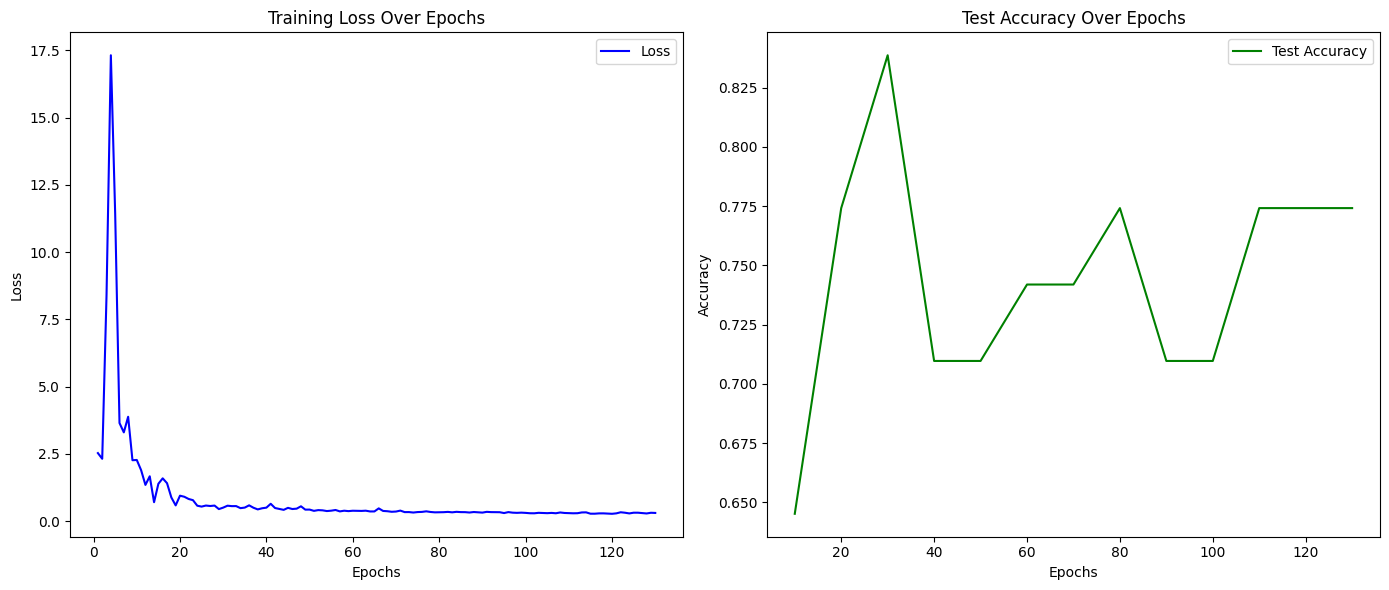

In [288]:
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(10, 10 * len(accuracies) + 1, 10), accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

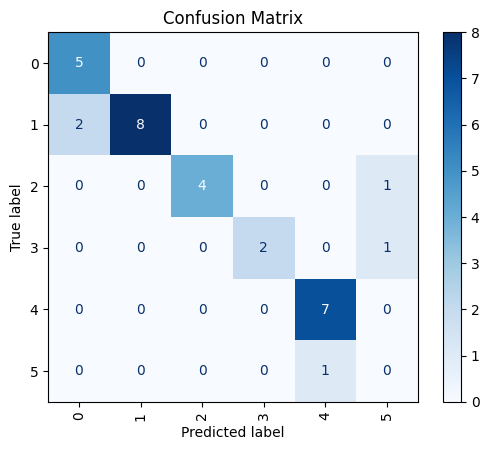

In [289]:
model.eval()
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1)
    true = y

# Ensure test_mask is boolean
test_mask_np = test_mask.bool()

# Filter predictions and true labels for test set
pred_test = pred[test_mask_np]
true_test = true[test_mask_np]

# Convert to CPU and use lists for sklearn compatibility
pred_test = pred_test.cpu().tolist()
true_test = true_test.cpu().tolist()

# Compute confusion matrix
cm = confusion_matrix(true_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=torch.unique(y).cpu().tolist())
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()